The project focuses on using TensorFlow and PyTorch libraries to process and classify images of potatoes, aiming to identify different diseases and conditions such as Dry Rot, Common Scab, and others.
1. Installation of necessary libraries such as TensorFlow, PyTorch, torchvision, and other related packages.
2. Mounting Google Drive to access the dataset stored there.
3. The images are stored in Google Drive, and the data path is specified. - Image transformations are applied to standardize the size and enhance the model training process. These transformations include resizing, cropping, and normalizing the images.
4. Utilization of a pre-trained ResNet model from Hugging Face's transformers library.
5. The model is fine-tuned for the specific task by adjusting the final layers to classify several potato conditions.
6. Training and validation data splits are defined, and data loaders are set up to handle batch processing   during model training.
7. Hyperparameters such as learning rate, batch size, and optimizer type are dynamically selected using the Optuna library, which performs hyperparameter optimization.
8. The training process involves adjusting weights through backpropagation and using a scheduler to adjust the learning rate over epochs.
9. The model's performance is evaluated based on its accuracy in classifying the test images.
10. Several trials are conducted to find the best model configuration, with results indicating improvements in validation accuracy through hyperparameter tuning.

In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import random
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset_path = '/content/drive/MyDrive/potato_stuff'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)


In [ ]:
from pathlib import Path
import random


data_path = Path("/content/drive/MyDrive/potato_stuff")


if not data_path.exists():
    print("The specified path does not exist:", data_path)
else:

    class_images = {}


    for sub_dir in [d for d in data_path.iterdir() if d.is_dir()]:

        files = [f for f in sub_dir.iterdir() if f.is_file()]

        print(f"Class {sub_dir.name} has a total of {len(files)} images.")

        num_samples = 5
        if len(files) >= num_samples:
            class_images[sub_dir.name] = random.sample(files, num_samples)
        else:
            class_images[sub_dir.name] = files

    for class_name, images in class_images.items():
        print(f"Class {class_name} has {len(images)} sampled images: {[image.name for image in images]}")


Class Dry Rot has a total of 60 images.
Class Common Scab has a total of 62 images.
Class Miscellaneous has a total of 74 images.
Class Blackleg has a total of 60 images.
Class Pink Rot has a total of 57 images.
Class Healthy Potatoes has a total of 80 images.
Class Black Scurf has a total of 58 images.
Class Dry Rot has 5 sampled images: ['12.jpg', '24.jpg', '55.jpg', '43.jpg', '18.jpg']
Class Common Scab has 5 sampled images: ['28.jpg', '47.jpg', '35.jpg', '9.jpg', '13.jpg']
Class Miscellaneous has 5 sampled images: ['13.jpg', '51.jpg', '28.jpg', '70.jpg', '61.jpg']
Class Blackleg has 5 sampled images: ['37.jpeg', '49.jpg', '57.jpg', '47.jpg', '40.jpg']
Class Pink Rot has 5 sampled images: ['56.jpg', '6.jpg', '18.jpg', '1.jpg', '13.jpg']
Class Healthy Potatoes has 5 sampled images: ['34.jpg', '7.jpg', '42.jpg', '18.jpg', '39.jpg']
Class Black Scurf has 5 sampled images: ['49.jpg', '34.jpg', '50.jpg', '1.jpg', '36.jpg']


In [ ]:
!pip install matplotlib Pillow


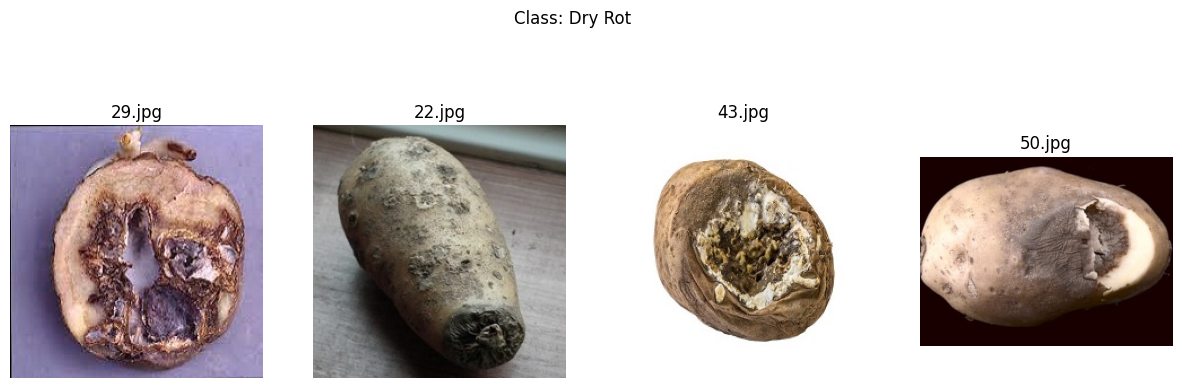

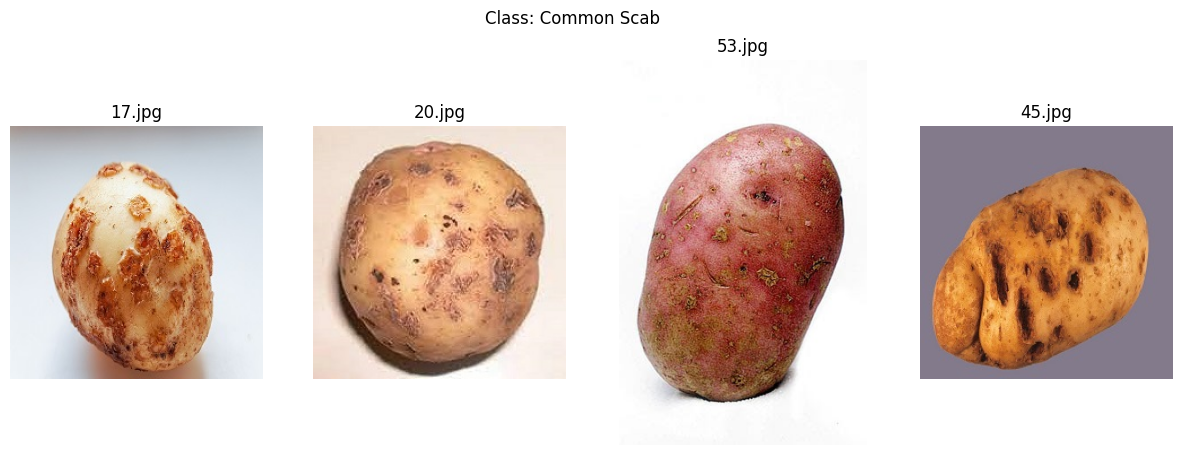

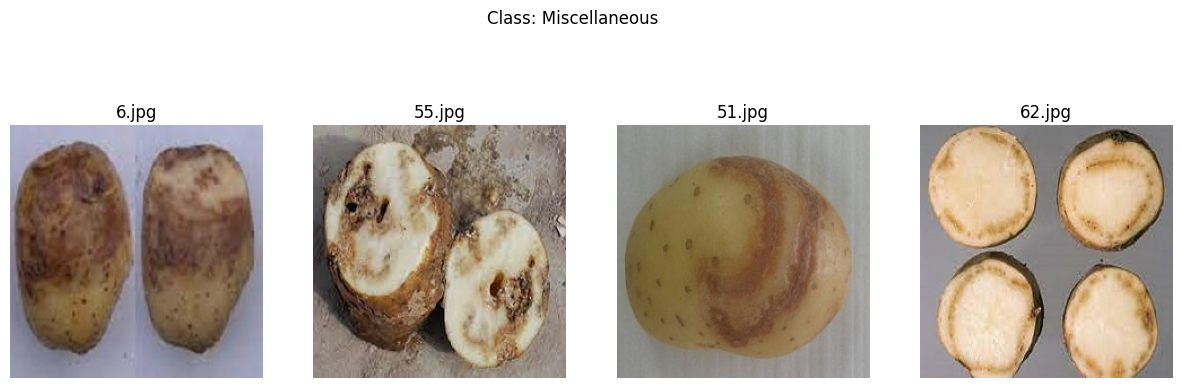

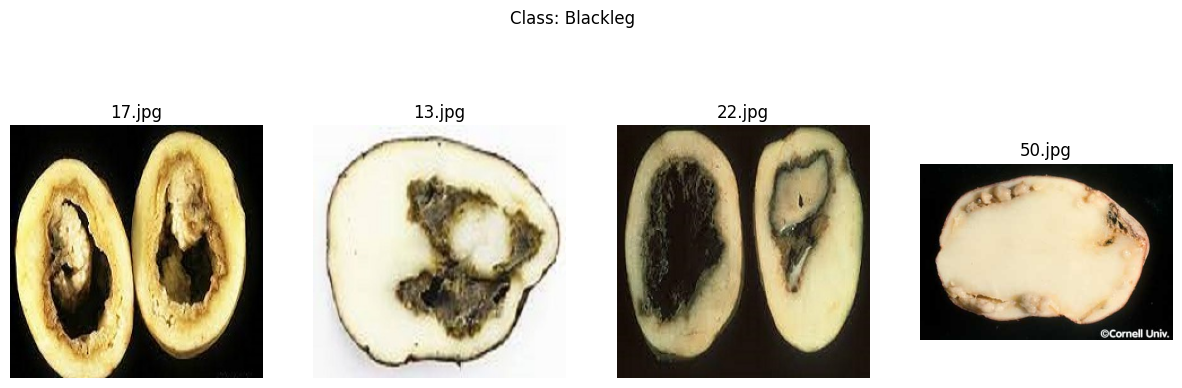

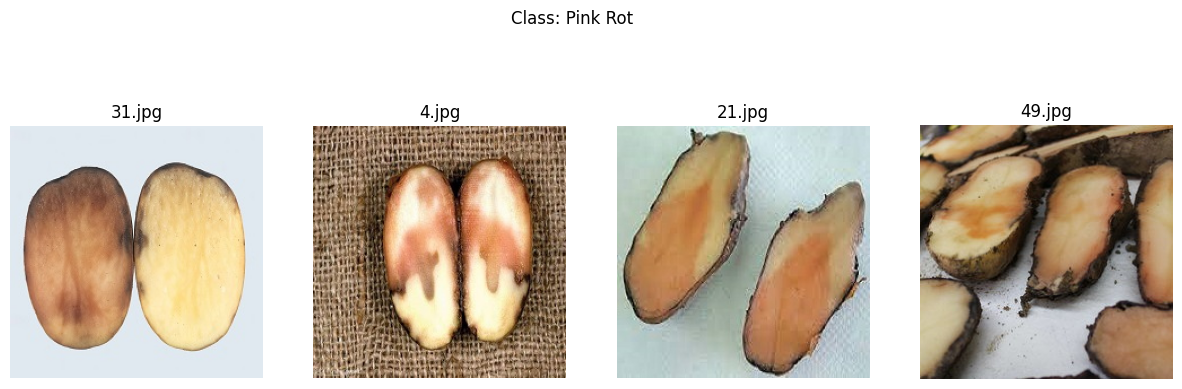

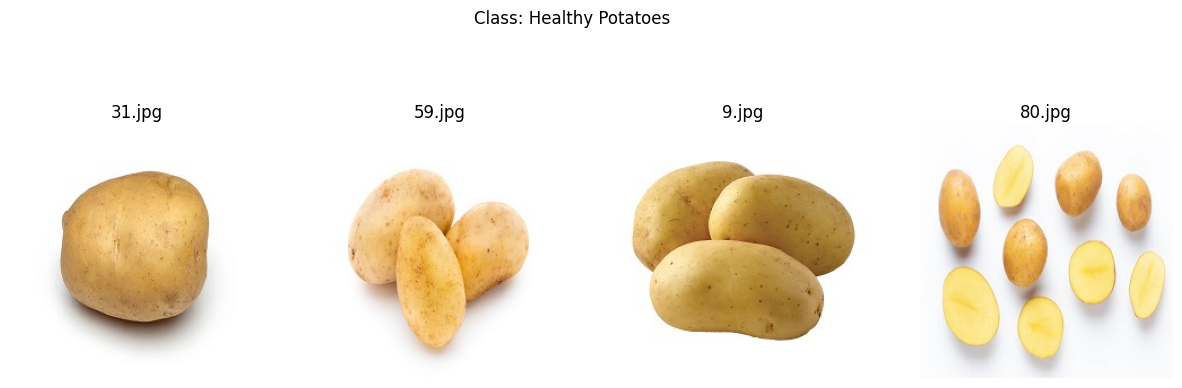

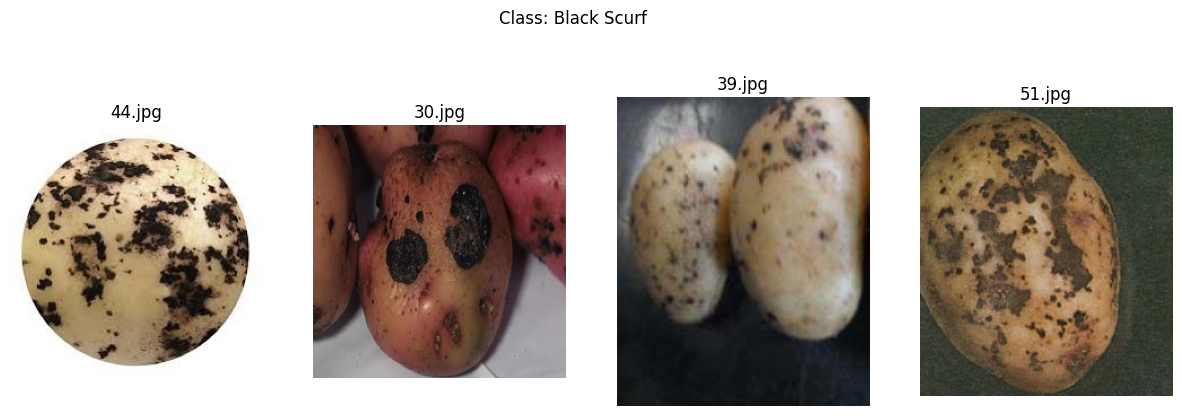

In [ ]:
import os
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt



if not data_path.exists():
    print("The specified path does not exist:", data_path)
else:

    for sub_dir in [d for d in data_path.iterdir() if d.is_dir()]:

        files = [f for f in sub_dir.iterdir() if f.is_file()]

        selected_files = random.sample(files, min(len(files), 4))

        fig, axes = plt.subplots(1, len(selected_files), figsize=(15, 5))
        fig.suptitle(f'Class: {sub_dir.name}')

        for ax, image_path in zip(axes, selected_files):
            img = Image.open(image_path)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(image_path.name)

        plt.show()


In [ ]:
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
from transformers import AutoModelForImageClassification
import torch.nn as nn

# Load the model
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")

# Assuming 'n_classes' is the number of your target classes
n_classes = len(dataset.classes)

model.classifier[1] = nn.Linear(in_features=2048, out_features=n_classes)

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last 5 layers
unfrozen_layer_count = 0
for param in reversed(list(model.parameters())):
    param.requires_grad = True
    unfrozen_layer_count += 1
    if unfrozen_layer_count == 5:
        break


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(model)
model = model.to(device)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [ ]:
!pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.0 MB/s eta 0:00:00


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from transformers import Trainer, TrainingArguments
# from transformers import AutoModelForImageClassification
# import optuna
# from torch.optim.lr_scheduler import StepLR


# # Assuming 'dataset' and related DataLoader 'train_loader', 'val_loader' are defined

# def objective(trial):
#     # Define the hyperparameters to tune
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
#     num_train_epochs = trial.suggest_categorical('num_train_epochs', [20, 40, 50])
#     per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [16, 32, 64])
#     optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
#     step_size = trial.suggest_int('step_size', 10, 50)
#     gamma = trial.suggest_float('gamma', 0.1, 0.5)

#     # Optimizer setup
#     if optimizer_name == "Adam":
#         optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     else:
#         optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#     # Scheduler setup
#     scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

#     criterion = nn.CrossEntropyLoss()
#     best_accuracy = 0

#     for epoch in range(num_train_epochs):
#         model.train()
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()

#             outputs = model(images)
#             loss = criterion(outputs.logits, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         model.eval()
#         val_loss = 0.0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs.logits, labels)
#                 val_loss += loss.item()

#                 _, predicted = torch.max(outputs.logits.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         val_accuracy = 100 * correct / total
#         if val_accuracy > best_accuracy:
#             best_accuracy = val_accuracy  # Update best accuracy for this trial

#         # print(f"Epoch:{epoch} validation accuracy:{val_accuracy}")

#     return best_accuracy  # return the best accuracy achieved during this trial

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=25)

# print("Best trial:")
# trial = study.best_trial
# print(f"  Best Validation Accuracy: {trial.value}%")
# print("  Best Hyperparameters:")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# # Print the overall best accuracy from all trials



In [ ]:
print(f"Overall Best Accuracy: {study.best_value}%")

we can conclude the loss is decreasing with epochs and the model is able to learn the complex image representations by using the pre trained resnet model

Fine - tuning the resnet model by unfreezing the last layers may have increased the accuracy a bit more because there will be more training parameters specific to the task .

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForImageClassification
import optuna
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
import matplotlib.pyplot as plt



def objective(trial):
    # Hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-2, log=True)
    num_train_epochs = trial.suggest_categorical('num_train_epochs', [20, 40, 50])
    batch_size = trial.suggest_categorical('per_device_train_batch_size', [16, 32, 64])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    step_size = trial.suggest_int('step_size', 10, 50)
    gamma = trial.suggest_float('gamma', 0.1, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)

    # Optimizer and scheduler setup
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    criterion = nn.CrossEntropyLoss()
    training_losses, validation_losses, validation_accuracies = [], [], []
    best_accuracy = 0

    # Training loop
    for epoch in range(num_train_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        training_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_losses.append(val_loss / len(val_loader))
        val_accuracy = 100 * correct / total
        validation_accuracies.append(val_accuracy)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy  # Update best accuracy for this trial



    return best_accuracy

# Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best trial:")
trial = study.best_trial
print(f"Best Validation Accuracy: {trial.value}%")
print("Best Hyperparameters:")
for key, value in trial.params.items():
    print(f"{key}: {value}")


[I 2024-05-05 21:41:39,926] A new study created in memory with name: no-name-e86af1ab-bbc8-4e46-b723-8f6b39d26440
[I 2024-05-05 21:43:11,412] Trial 0 finished with value: 60.43956043956044 and parameters: {'learning_rate': 1.609350910417982e-06, 'num_train_epochs': 20, 'per_device_train_batch_size': 16, 'optimizer': 'SGD', 'step_size': 44, 'gamma': 0.3741971103097186, 'weight_decay': 1.2470685413530165e-05}. Best is trial 0 with value: 60.43956043956044.
[I 2024-05-05 21:46:16,049] Trial 1 finished with value: 60.43956043956044 and parameters: {'learning_rate': 2.3870430202103013e-06, 'num_train_epochs': 40, 'per_device_train_batch_size': 32, 'optimizer': 'SGD', 'step_size': 29, 'gamma': 0.254456459657261, 'weight_decay': 0.00021319177224930189}. Best is trial 0 with value: 60.43956043956044.
[I 2024-05-05 21:47:49,969] Trial 2 finished with value: 61.53846153846154 and parameters: {'learning_rate': 2.6851621084059075e-05, 'num_train_epochs': 20, 'per_device_train_batch_size': 32, 'opt

Best trial:
Best Validation Accuracy: 74.72527472527473%
Best Hyperparameters:
learning_rate: 0.0020060718842881964
num_train_epochs: 40
per_device_train_batch_size: 64
optimizer: AdamW
step_size: 21
gamma: 0.3460379841393182
weight_decay: 0.0005955429287475978


In [ ]:
print(f"Overall Best Accuracy: {study.best_value}%")

Overall Best Accuracy: 74.72527472527473%


In [ ]:
validation_accuracies

NameError: name 'validation_accuracies' is not defined

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0005956)
scheduler = StepLR(optimizer, step_size=21, gamma=0.3460)

criterion = nn.CrossEntropyLoss()
training_losses, validation_losses, validation_accuracies = [], [], []
best_accuracy = 0
val_accuracies =[FutureWarning]

# Training loop
for epoch in range(40):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    training_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_losses.append(val_loss / len(val_loader))
    val_accuracy = 100 * correct / total
    validation_accuracies.append(val_accuracy)

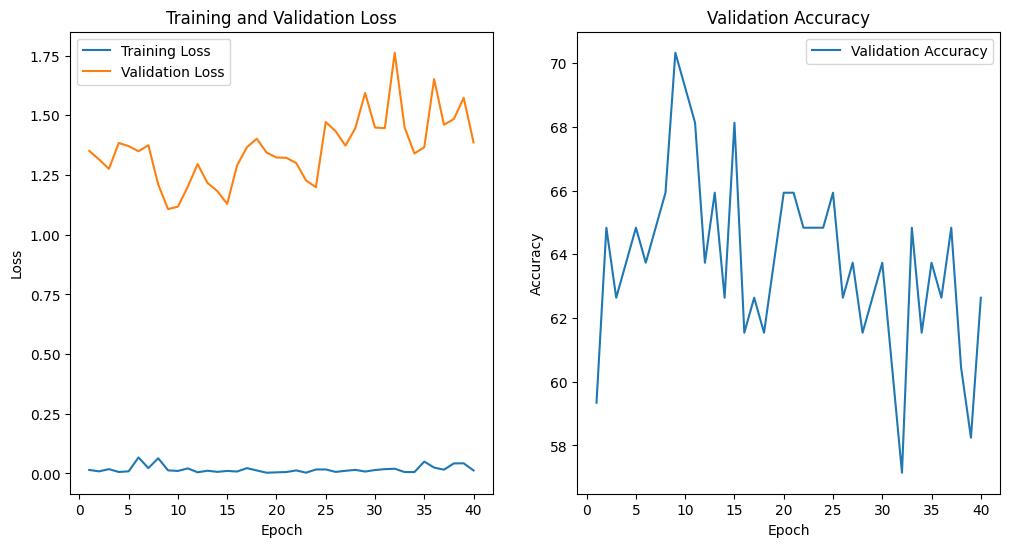

In [ ]:
    # Plot training and validation metrics
    epochs = range(1,  41)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()